# Code for the 2022 IMI Big Data and Artificial Intelligence Case Competition
In this Git, we conducted several analyses to predict the probability of corporate default from financial data of Canadian medium-sized entities. Any sensitive information (e.g., customer ID info) has been removed or modified as necessary.
The three primary methods to tackle this problem are logisitc regression, support vector machine (SVM), and XGBoost to assess the following specific problems:
1. Binary classification to predict good (investment grade) vs bad (non-investment grade) credit rating
2. Conduct multi-class classification to predict the credit rating of a medium-sized entity ranging from 1 (the best credit and least likely to default on a loan) to 17 (the worst credit and most likely to default on a loan)

# Major highlights of results
1. Cleaned the data by removing missing values and outliers
2. Engineered new features and identified key features using recurssive feature elimination
3. Achieved good performance for both binary and multiclass classification through hyperparameter tuning
4. Discovered data structure using clustering analysis


In [1]:
## Importing necessart packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Feature engineering

These features are engineered based on formulas and modified formulas from previous research on corporate PD (see Lu & Zhuo, 2021). Importantly, these features do not focus on one aspect of a company's finances (e.g., profitability), but serve to paint a more holistic view in predicting PD.

In [ ]:
data_short['CURRENT_RATIO'] = data_short['CURRENTASSET_Y0'] / data_short['CURRENTLIABILITY_Y0']
data_short['ACID_RATIO'] = (data_short['CURRENTASSET_Y0'] - data_short['Inventory_Y0']) / data_short['CURRENTLIABILITY_Y0']
data_short['CASH_RATIO'] = data_short['CURRENTLIABILITY_Y0'] / data_short['CCE_Y0']
data_short['CASH_RATIO2'] = (data_short['CURRENTLIABILITY_Y0'] + data_short['NONCURRLIA_Y0']) / data_short['CCE_Y0']
data_short['WCL'] = data_short['CURRENTLIABILITY_Y0'] / (data_short['CURRENTLIABILITY_Y0'] + data_short['NONCURRLIA_Y0'])
data_short['LEVERAGE'] = data_short['TOTALASSET_Y0'] / (data_short['CURRENTLIABILITY_Y0'] + data_short['NONCURRLIA_Y0'])
data_short['SR'] = data_short['EBITDA_Y0'] / data_short['TOTALEQUITY_Y0']
data_short['SBTL'] = data_short['TOTALREVENUE_Y0'] / data_short['TOTALEQUITY_Y0']
data_short['FCF'] = data_short['FCF_Y0'] / (data_short['CURRENTLIABILITY_Y0'] + data_short['NONCURRLIA_Y0'])
data_short['OPE'] = data_short['OPERPROFIT_Y0'] / data_short['TOTALREVENUE_Y0']
data_short['ROA'] = data_short['NETSALES_Y0'] / data_short['TOTALASSET_Y0']
data_short['OROA'] = data_short['OPERPROFIT_Y0'] / data_short['TOTALASSET_Y0']
data_short['ROE'] = data_short['NETSALES_Y0'] / data_short['TOTALEQUITY_Y0']
data_short['CAPTIAL_STRUCTURE'] = data_short['TOTALEQUITY_Y0'] / data_short['TOTALASSET_Y0']
data_short['SHORTTERM_LEVERAGE'] = data_short['CURRENTLIABILITY_Y0'] / data_short['TOTALNETWORTH_Y0']
data_short['LIQUIDITY'] = data_short['CCE_Y0'] / data_short['TOTALASSET_Y0']
data_short['DEBT_SERVICE_CAPACITY'] = data_short['NETPROFIT_Y0'] / (data_short['CURRENTLIABILITY_Y0'] + data_short['NONCURRLIA_Y0'])
data_short['EFFICIENCY'] = data_short['NETPROFIT_Y0'] / data_short['TOTALREVENUE_Y0']
data_short['ACID'] = (data_short['CCE_Y0'] + data_short['ARTurnover_Y0']) / data_short['CURRENTLIABILITY_Y0']
data_short['DEBT_COVERAGE'] = data_short['EBITDA_Y0'] / data_short['TOTINTEXP_Y0']
data_short['EBITDA_RATIO'] = data_short['EBITDA_Y0'] / data_short['NETSALES_Y0']

data_short.head()

,CUSTOMER_ID,Corp_Residence_Country_Code,BR Code,Final_IG,B_PLUS_FLAG,EBITDA_Y0,TOTALASSET_Y0,TOTALDEBT_Y0,TOTALREVENUE_Y0,CURRENTASSET_Y0,FIXEDASSET_Y0,CURRENTLIABILITY_Y0,NONCURRLIA_Y0,TOTALEQUITY_Y0,TOTALNETWORTH_Y0,CAPITALIZATION_Y0,TOTINTEXP_Y0,LEASERENTEXP_Y0,EBITDAR_Y0,receivabledays_Y0,INVENTORYDAYS_Y0,payableDAYS_Y0,Capex2Dep_Y0,tangibleNetWorth_Y0,FIXEDCHARGECOV_Y0,DEBTSERVCOV_Y0,NETPROFIT_Y0,NETSALES_Y0,ASSETTURNOVER_Y0,OPERPROFIT_Y0,ARTurnover_Y0,Inventory_Y0,RETAINED_EARNINGS_Y0,FCF_Y0,CCE_Y0,CURRENT_RATIO,ACID_RATIO,CASH_RATIO,CASH_RATIO2,WCL,LEVERAGE,SR,SBTL,FCF,OPE,ROA,OROA,ROE,CAPTIAL_STRUCTURE,SHORTTERM_LEVERAGE,LIQUIDITY,DEBT_SERVICE_CAPACITY,EFFICIENCY,ACID,DEBT_COVERAGE,EBITDA_RATIO
0,1576,1,5,5,1,575863.911214,619611.510181,623105.791017,611355.411490,620745.952718,609095.636450,578103.988392,600890.935743,596259.219747,578045.252633,571736.508285,611986.404942,603141.577521,585871.251511,604601.169985,590472.808115,582917.058057,603769.043190,590316.935078,579949.325730,573565.511062,623675.986993,609912.733618,570091.364648,575870.723892,593269.795473,600112.382878,604537.606945,606861.990009,575350.400174,1.073762,0.035692,1.004786,2.049177,0.490336,0.525542,0.965795,1.025318,0.514728,0.941957,0.984347,0.929406,1.022899,0.962311,1.000102,0.928566,0.528990,1.020153,2.021471,0.940975,0.944174
1,648,0,12,8,1,613829.072017,608391.483917,585464.960100,608591.366569,618999.144319,578343.317529,603655.551037,605298.293603,577735.145730,585900.805747,585225.732357,603652.451410,610421.314919,615972.913531,614134.979471,583797.304612,623541.230342,599099.056296,592856.378966,599586.156088,572606.634235,628443.444334,618384.136760,587195.266426,613853.875298,614104.443488,605642.248232,618703.592690,586607.548841,580199.620976,1.025418,0.022127,1.040427,2.083686,0.499321,0.503238,1.062475,1.053409,0.485219,1.008647,1.016425,1.008978,1.070359,0.949611,1.030303,0.953662,0.519824,1.032620,1.978453,1.016858,0.992634
2,13395,0,19,5,1,585059.299344,591791.219692,584513.060799,615999.168162,582358.584899,621919.270235,620046.519867,624582.882164,601679.290137,609409.181664,606435.590692,569227.108284,619543.967706,610683.455442,596054.212034,575626.390128,627037.437178,599367.108922,596121.697084,584225.743532,602652.271667,600047.184269,592635.899148,583240.465017,573787.307640,568608.114496,582067.967917,581638.119480,604725.209898,587097.755174,0.939218,0.000469,1.056121,2.119970,0.498178,0.475476,0.972377,1.023800,0.485868,0.931474,1.001427,0.969577,0.984970,1.016709,1.017455,0.992069,0.482109,0.974104,1.863902,1.027813,0.987215
3,13610,0,21,6,1,602633.453330,605734.046655,572819.231810,580268.738890,603502.907779,587656.502937,594459.641503,619566.756533,619479.765547,604536.927056,580297.183877,569961.820007,606591.032767,619801.013765,574771.307851,602936.391037,591215.238520,598976.604350,622499.239155,578306.677265,627416.565405,604105.636761,623874.861527,622522.878950,623917.451440,601735.110177,577857.023554,611712.655379,616771.612801,587751.860948,1.015213,0.043142,1.011413,2.065542,0.489660,0.498946,0.972806,0.936703,0.508038,1.075222,1.029948,1.030019,1.007095,1.022693,0.983331,0.970313,0.497605,1.041079,2.000955,1.057322,0.965952
4,11392,1,5,8,1,579642.861183,622028.317955,624452.225874,620551.783461,596700.028726,612349.104167,592262.918727,597934.417421,583194.794576,621499.359273,615342.619863,622286.109025,621920.555494,618913.135595,598519.816311,579104.823409,625597.110237,618945.335399,591480.284064,627623.514077,592446.164542,593610.324087,579650.958137,609655.451918,586550.570176,582009.807305,608450.559913,598009.014189,586892.463429,599979.065552,1.007492,-0.019840,0.987139,1.983731,0.497617,0.522626,0.993910,1.064056,0.493105,0.945208,0.931872,0.942964,0.993923,0.937570,0.952958,0.964553,0.498749,0.956585,1.995716,0.931473,0.999986


In [ ]:
data_short.shape

(15845, 56)

# Initial model selection

Take 10% of the data to try out a few models and select which model to proceed with

In [ ]:
data_init, data_rest = train_test_split(data_short, test_size=0.8, random_state=42)

In [ ]:
data_init

,CUSTOMER_ID,Corp_Residence_Country_Code,BR Code,Final_IG,B_PLUS_FLAG,EBITDA_Y0,TOTALASSET_Y0,TOTALDEBT_Y0,TOTALREVENUE_Y0,CURRENTASSET_Y0,FIXEDASSET_Y0,CURRENTLIABILITY_Y0,NONCURRLIA_Y0,TOTALEQUITY_Y0,TOTALNETWORTH_Y0,CAPITALIZATION_Y0,TOTINTEXP_Y0,LEASERENTEXP_Y0,EBITDAR_Y0,receivabledays_Y0,INVENTORYDAYS_Y0,payableDAYS_Y0,Capex2Dep_Y0,tangibleNetWorth_Y0,FIXEDCHARGECOV_Y0,DEBTSERVCOV_Y0,NETPROFIT_Y0,NETSALES_Y0,ASSETTURNOVER_Y0,OPERPROFIT_Y0,ARTurnover_Y0,Inventory_Y0,RETAINED_EARNINGS_Y0,FCF_Y0,CCE_Y0,CURRENT_RATIO,ACID_RATIO,CASH_RATIO,CASH_RATIO2,WCL,LEVERAGE,SR,SBTL,FCF,OPE,ROA,OROA,ROE,CAPTIAL_STRUCTURE,SHORTTERM_LEVERAGE,LIQUIDITY,DEBT_SERVICE_CAPACITY,EFFICIENCY,ACID,DEBT_COVERAGE,EBITDA_RATIO
16234,13322,1,5,7,1,602767.556955,572803.130112,602057.291412,616819.117023,596558.538303,591456.016235,590167.050404,570825.969679,595141.818851,576191.418143,614104.177266,583689.457324,624047.863668,609811.912192,600413.206976,5.852003e+05,5.702626e+05,588334.922836,614252.621089,570681.744218,593823.649113,608432.949698,599903.442330,593209.175836,583549.452306,572770.059524,597855.869912,610777.220872,588238.119265,598472.859425,1.010830,-0.002198,0.986122,1.939926,0.508330,0.493373,1.012813,1.036424,0.506668,0.946063,1.047312,1.018761,1.008001,1.038999,1.024255,1.044814,0.524063,0.986404,1.984596,1.032685,1.004774
5906,6373,0,30,5,1,586110.806271,626765.261433,593488.232944,611856.941683,624478.692088,632747.363073,603252.894972,605927.184968,591482.188167,628027.479603,573301.823705,625219.069193,606121.541290,588805.126108,579667.546073,1.024594e+09,1.026138e+09,606307.392247,619076.987167,589963.703949,598752.973434,603386.578254,629426.070493,588363.865996,598041.140709,592375.343789,622847.771949,589367.505787,624832.294516,614905.259184,1.035186,0.002704,0.981050,1.966449,0.498894,0.518339,0.990919,1.034447,0.516740,0.977420,1.004245,0.954171,1.064151,0.943706,0.960552,0.981077,0.499005,0.986156,2.001284,0.937449,0.931183
5715,8901,1,5,7,1,600021.428808,619390.390143,598230.038503,683620.107874,623005.380901,638339.272325,621934.560631,615299.367968,597394.540238,634760.494923,651131.363367,579225.781794,584653.652839,602591.925644,595251.977106,6.066299e+05,6.237065e+05,618588.233188,632572.066348,627124.956676,603031.518221,606265.081518,639191.085636,608320.159027,605027.564367,602347.937433,573996.995719,597567.054982,629879.864771,624112.147448,1.001722,0.078800,0.996511,1.982390,0.502681,0.500625,1.004397,1.144336,0.509103,0.885035,1.031968,0.976811,1.069965,0.964488,0.979794,1.007623,0.490017,0.886845,1.972008,1.035902,0.938720
4862,6614,1,5,5,1,622558.534588,646385.258020,623653.878704,631213.103148,631054.180727,657623.043155,594809.699009,618172.166091,611130.579196,632042.594221,593075.081760,572208.691546,609932.011586,605897.005127,602442.492607,9.837303e+08,9.617692e+08,572011.725259,627664.816231,576470.032778,586493.965954,624126.315427,596661.078335,621397.716831,577990.151158,585473.663266,617045.910435,599620.440477,590012.487002,623271.446986,1.060935,0.023551,0.954335,1.946153,0.490370,0.532889,1.018700,1.032861,0.486415,0.915681,0.923073,0.894188,0.976323,0.945459,0.941091,0.964241,0.514539,0.988773,2.032154,1.087992,1.043404
10574,13625,0,12,5,1,619853.654622,613632.747642,625799.545782,601614.663489,600005.518180,582906.409861,606946.267019,606325.321213,590635.764623,572578.496780,600028.625547,599024.541599,616673.588172,611811.946368,570363.993617,5.942173e+05,5.899069e+05,611494.662986,579000.239036,573835.541823,615314.310169,619181.159381,632232.387959,612452.292580,589142.433566,597368.027927,621615.885671,605380.296805,576908.669368,578251.452574,0.988564,-0.035605,1.049623,2.098173,0.500256,0.505767,1.049469,1.018588,0.475498,0.979269,1.030311,0.960090,1.070427,0.962523,1.060023,0.942341,0.510340,1.029199,1.936942,1.034772,0.980421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
cus_ID = data_init['CUSTOMER_ID'].unique()
ID_train, ID_test = train_test_split(cus_ID, test_size=0.2, random_state=42)

In [ ]:
X_train = data_init[data_init['CUSTOMER_ID'].isin(ID_train)].drop(['CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG'], axis=1)
X_test = data_init[data_init['CUSTOMER_ID'].isin(ID_test)].drop(['CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG'], axis=1)
y_train = data_init[data_init['CUSTOMER_ID'].isin(ID_train)][['B_PLUS_FLAG']]
y_test = data_init[data_init['CUSTOMER_ID'].isin(ID_test)][['B_PLUS_FLAG']]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2541, 53), (628, 53), (2541, 1), (628, 1))

In [ ]:
scaler = StandardScaler()
X_train[X_train.columns[2:]] = scaler.fit_transform(X_train[X_train.columns[2:]])
X_test[X_test.columns[2:]] = scaler.transform(X_test[X_test.columns[2:]])
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train

,EBITDA_Y0,TOTALASSET_Y0,TOTALDEBT_Y0,TOTALREVENUE_Y0,CURRENTASSET_Y0,FIXEDASSET_Y0,CURRENTLIABILITY_Y0,NONCURRLIA_Y0,TOTALEQUITY_Y0,TOTALNETWORTH_Y0,CAPITALIZATION_Y0,TOTINTEXP_Y0,LEASERENTEXP_Y0,EBITDAR_Y0,receivabledays_Y0,INVENTORYDAYS_Y0,payableDAYS_Y0,Capex2Dep_Y0,tangibleNetWorth_Y0,FIXEDCHARGECOV_Y0,DEBTSERVCOV_Y0,NETPROFIT_Y0,NETSALES_Y0,ASSETTURNOVER_Y0,OPERPROFIT_Y0,ARTurnover_Y0,Inventory_Y0,RETAINED_EARNINGS_Y0,FCF_Y0,CCE_Y0,CURRENT_RATIO,ACID_RATIO,CASH_RATIO,CASH_RATIO2,WCL,LEVERAGE,SR,SBTL,FCF,OPE,...,BR Code_48,BR Code_49,BR Code_50,BR Code_51,BR Code_52,BR Code_53,BR Code_54,BR Code_55,BR Code_56,BR Code_57,BR Code_58,BR Code_59,BR Code_60,BR Code_62,BR Code_63,BR Code_64,BR Code_66,BR Code_67,BR Code_68,BR Code_69,BR Code_71,BR Code_72,BR Code_74,BR Code_75,BR Code_76,BR Code_77,BR Code_78,BR Code_80,BR Code_81,BR Code_82,BR Code_83,BR Code_87,BR Code_90,BR Code_91,BR Code_92,BR Code_93,BR Code_94,BR Code_96,BR Code_101,BR Code_107
16234,0.178009,-1.692980,0.064050,0.407031,-0.283782,-0.730527,-0.628570,-1.647075,-0.319033,-1.429419,0.532606,-0.878963,1.504265,0.604232,0.096036,-0.438452,-0.438516,-0.615852,0.742391,-1.613825,-0.261339,0.548195,-0.383939,-0.289036,-0.886950,-1.514876,-0.122425,0.535956,-0.596459,-0.026933,0.221087,-0.118142,-0.454249,-0.951441,0.743834,-0.629147,0.333898,0.520689,0.448176,-0.915801,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5906,-0.794544,1.026840,-0.411991,0.175571,1.268126,1.253341,0.114022,0.352587,-0.523997,1.422020,-1.650819,1.534266,0.451923,-0.587633,-1.094771,2.346967,2.347983,0.423399,1.016843,-0.504446,0.029211,0.252872,1.018891,-0.568877,-0.060744,-0.375387,1.284370,-0.657581,1.489655,0.921656,0.801902,-0.000802,-0.578481,-0.574198,-0.167233,0.710648,-0.196230,0.476929,1.016007,-0.203774,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5715,0.017668,0.655129,-0.148567,3.522960,1.186233,1.522008,1.174164,0.886505,-0.192865,1.792395,2.514014,-1.138341,-0.808323,0.194591,-0.200220,-0.438394,-0.438370,1.133534,1.784559,1.633610,0.281402,0.421327,1.482896,0.583699,0.337569,0.204236,-1.465441,-0.200477,1.777400,1.453140,0.003881,1.820806,-0.199753,-0.347470,0.198463,-0.239981,0.130122,2.909489,0.585460,-2.301549,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4862,1.333564,2.015734,1.263813,1.078438,1.633616,2.448509,-0.365110,1.050164,0.576446,1.642887,-0.592708,-1.546094,0.675611,0.382111,0.212518,2.235812,2.173092,-1.559735,1.505392,-1.280798,-0.693374,1.466599,-0.538007,1.338993,-1.203899,-0.776523,0.957783,-0.086006,-0.495308,1.404609,1.415946,0.498244,-1.232901,-0.862867,-0.990333,1.491505,0.476424,0.441828,-0.693595,-1.605659,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10574,1.175632,0.364930,1.383013,-0.302180,-0.092186,-1.141298,0.323612,0.375268,-0.571403,-1.628162,-0.220608,0.012138,1.071367,0.717708,-1.628798,-0.438428,-0.438462,0.723351,-1.263067,-1.432373,1.005389,1.177200,1.152239,0.822350,-0.568081,-0.085204,1.215028,0.235091,-1.242314,-1.194249,-0.309885,-0.917841,1.101298,1.299301,-0.035747,0.035962,1.221424,0.125874,-1.309016,-0.161792,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12083,0.008798,0.307138,-1.246686,-0.474957,0.484778,-1.559897,-0.743009,-1.399225,-0.477504,0.232888,0.285942,0.173383,-1.383399,0.781362,0.585158,-0.438474,-0.438441,1.578398,1.334362,0.458991,-0.646657,-0.444396,0.628837,-1.630727,0.743660,0.543287,-0.481749,-0.519138,-0.181219,-0.806087,0.864374,0.704261,0.018665,-0.258067,0.477972,1.148354,0.332578,-0.076382,0.7

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

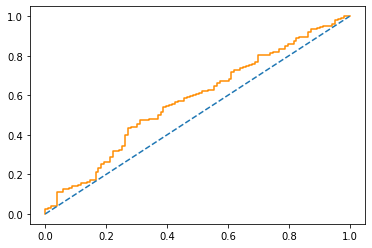

In [ ]:
model = SVC(probability=True, kernel='linear', class_weight='balanced')
model.fit(X_train, np.ravel(y_train))
pred_proba = model.predict_proba(X_test)
prob_default = pred_proba[:,1]
fallout_svm, sensitivity_svm, thresholds_svm = roc_curve(y_test, prob_default)
plt.plot(fallout_svm, sensitivity_svm, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [ ]:
auc = roc_auc_score(y_test, prob_default)
auc

0.5758853444290337

In [ ]:
model.score(X_test, y_test)

0.5573248407643312

In [ ]:
y_pred = model.predict(X_test)
target_names = ['Default', 'Non-default']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Default       0.20      0.58      0.30       103
 Non-default       0.87      0.55      0.68       525

    accuracy                           0.56       628
   macro avg       0.54      0.57      0.49       628
weighted avg       0.76      0.56      0.61       628



### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, np.ravel(y_train))

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
model.score(X_test, y_test)

0.5700636942675159

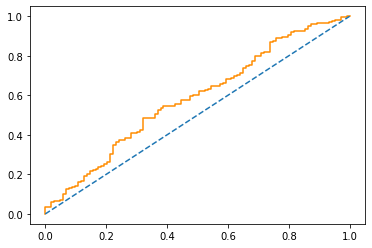

In [ ]:
pred_proba = model.predict_proba(X_test)
prob_default = pred_proba[:,1]
fallout_lg, sensitivity_lg, thresholds_lg = roc_curve(y_test, prob_default)
plt.plot(fallout_lg, sensitivity_lg, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [ ]:
auc = roc_auc_score(y_test, prob_default)
auc

0.5852981969486823

In [ ]:
y_pred = model.predict(X_test)
target_names = ['Default', 'Non-default']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Default       0.20      0.54      0.29       103
 Non-default       0.87      0.58      0.69       525

    accuracy                           0.57       628
   macro avg       0.53      0.56      0.49       628
weighted avg       0.76      0.57      0.63       628



In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, y_pred)

0.4299363057324841

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
np.sum(y_train['B_PLUS_FLAG']==0) / np.sum(y_train['B_PLUS_FLAG']==1)

0.17693376563223714

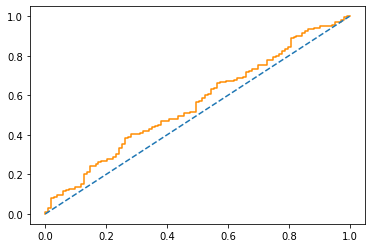

In [ ]:
model = xgb.XGBClassifier(scale_pos_weight=np.sum(y_train['B_PLUS_FLAG']==0)/np.sum(y_train['B_PLUS_FLAG']==1))
model.fit(X_train, np.ravel(y_train))
pred_proba = model.predict_proba(X_test)
prob_default = pred_proba[:,1]
fallout_xgb, sensitivity_xgb, thresholds_xgb = roc_curve(y_test, prob_default)
plt.plot(fallout_xgb, sensitivity_xgb, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [ ]:
auc = roc_auc_score(y_test, prob_default)
auc

0.557392510402219

In [ ]:
model.score(X_test, y_test)

0.6496815286624203

In [ ]:
y_pred = model.predict(X_test)
target_names = ['Default', 'Non-default']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Default       0.19      0.34      0.24       103
 Non-default       0.85      0.71      0.77       525

    accuracy                           0.65       628
   macro avg       0.52      0.53      0.51       628
weighted avg       0.74      0.65      0.69       628



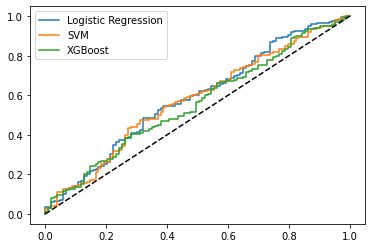

In [ ]:
# Visualizing all 3 methods of analysis so far to compare
plt.plot(fallout_lg, sensitivity_lg, label = 'Logistic Regression')
plt.plot(fallout_svm, sensitivity_svm, label = 'SVM')
plt.plot(fallout_xgb, sensitivity_xgb, label = 'XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color = 'k')
plt.legend()
plt.show()